### Analysis of Spatial Accessibility to Healthcare Facilities in Sub-Saharan Cities

This code evaluates spatial accessibility to healthcare facilities within formal urban areas across 19 sub-Saharan African cities. It calculates the proportion of the population within a specified travel time to the nearest hospital, considering uncertainty in travel time estimations.

#### Key Steps in the Code:

1. **Data Loading and Preparation**: 
   - Load CSV files containing total population and population in service areas.
   - Specify parameters such as land use type (`Formal` or `Informal`), hospital category (`C0` for all health facilities or `C2` for just hospitals), travel time of interest (some value between `1` and `120` minutes), and uncertainty factor (`0.2` is set as default).

2. **City-Specific Calculations**: 
   - For each city, the code filters the data by land use and sorts by travel time.
   - It then computes upper and lower travel time boundaries based on the specified uncertainty factor.
   - Using interpolation, it calculates the population reachable within these adjusted time bounds.

3. **Normalization and Aggregation**:
   - The code normalizes populations by dividing by the maximum population within each city's formal areas.
   - A dictionary `specified_time_data` aggregates the normalized population and uncertainty-adjusted bounds for each city.

4. **Data Visualization**:
   - The code generates two plots:
     - A **population vs. time plot**, where each city’s normalized population over time is shown with a different line style for easy identification.
     - A **scatter plot with error bars** for each city's population share accessible within the specified time (see 1.), accounting for uncertainty bounds.

5. **Data Saving**:
   - The code saves `specified_time_data` to a CSV file for further use.
   - It also inverts normalized population values for alternate analysis and calculates the percentage of the population outside the target travel time for each city.

This analysis provides insights into spatial accessibility disparities in healthcare services across different cities and highlights potential areas for targeted urban planning and intervention.



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_14803/3922788510.py:6: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_14803/3922788510.py:6: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_14803/3922788510.py:6: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4p

Data saved to specified_time_data_C2_Informal_15_min.csv


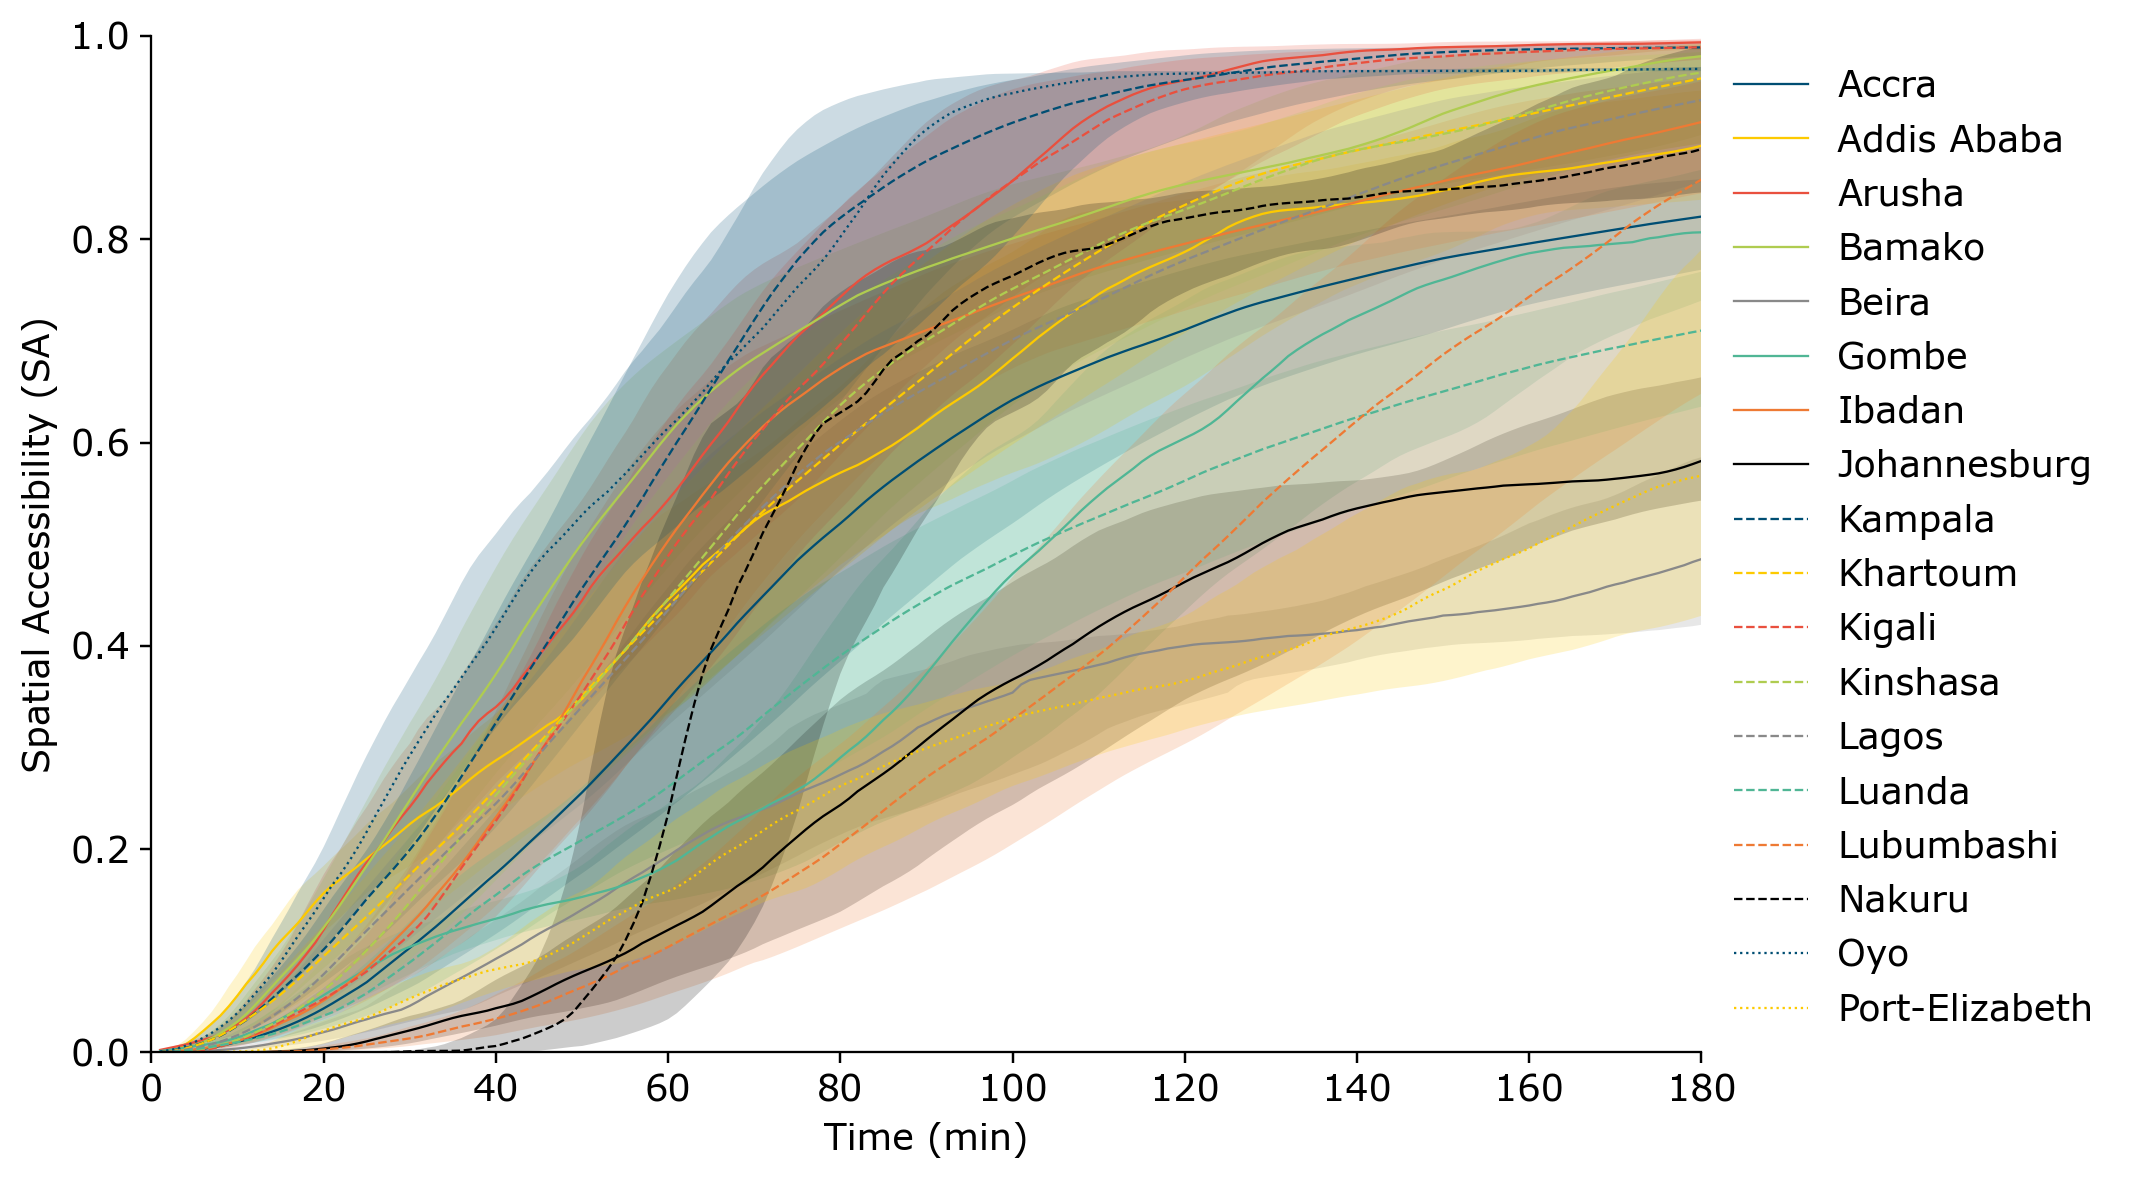

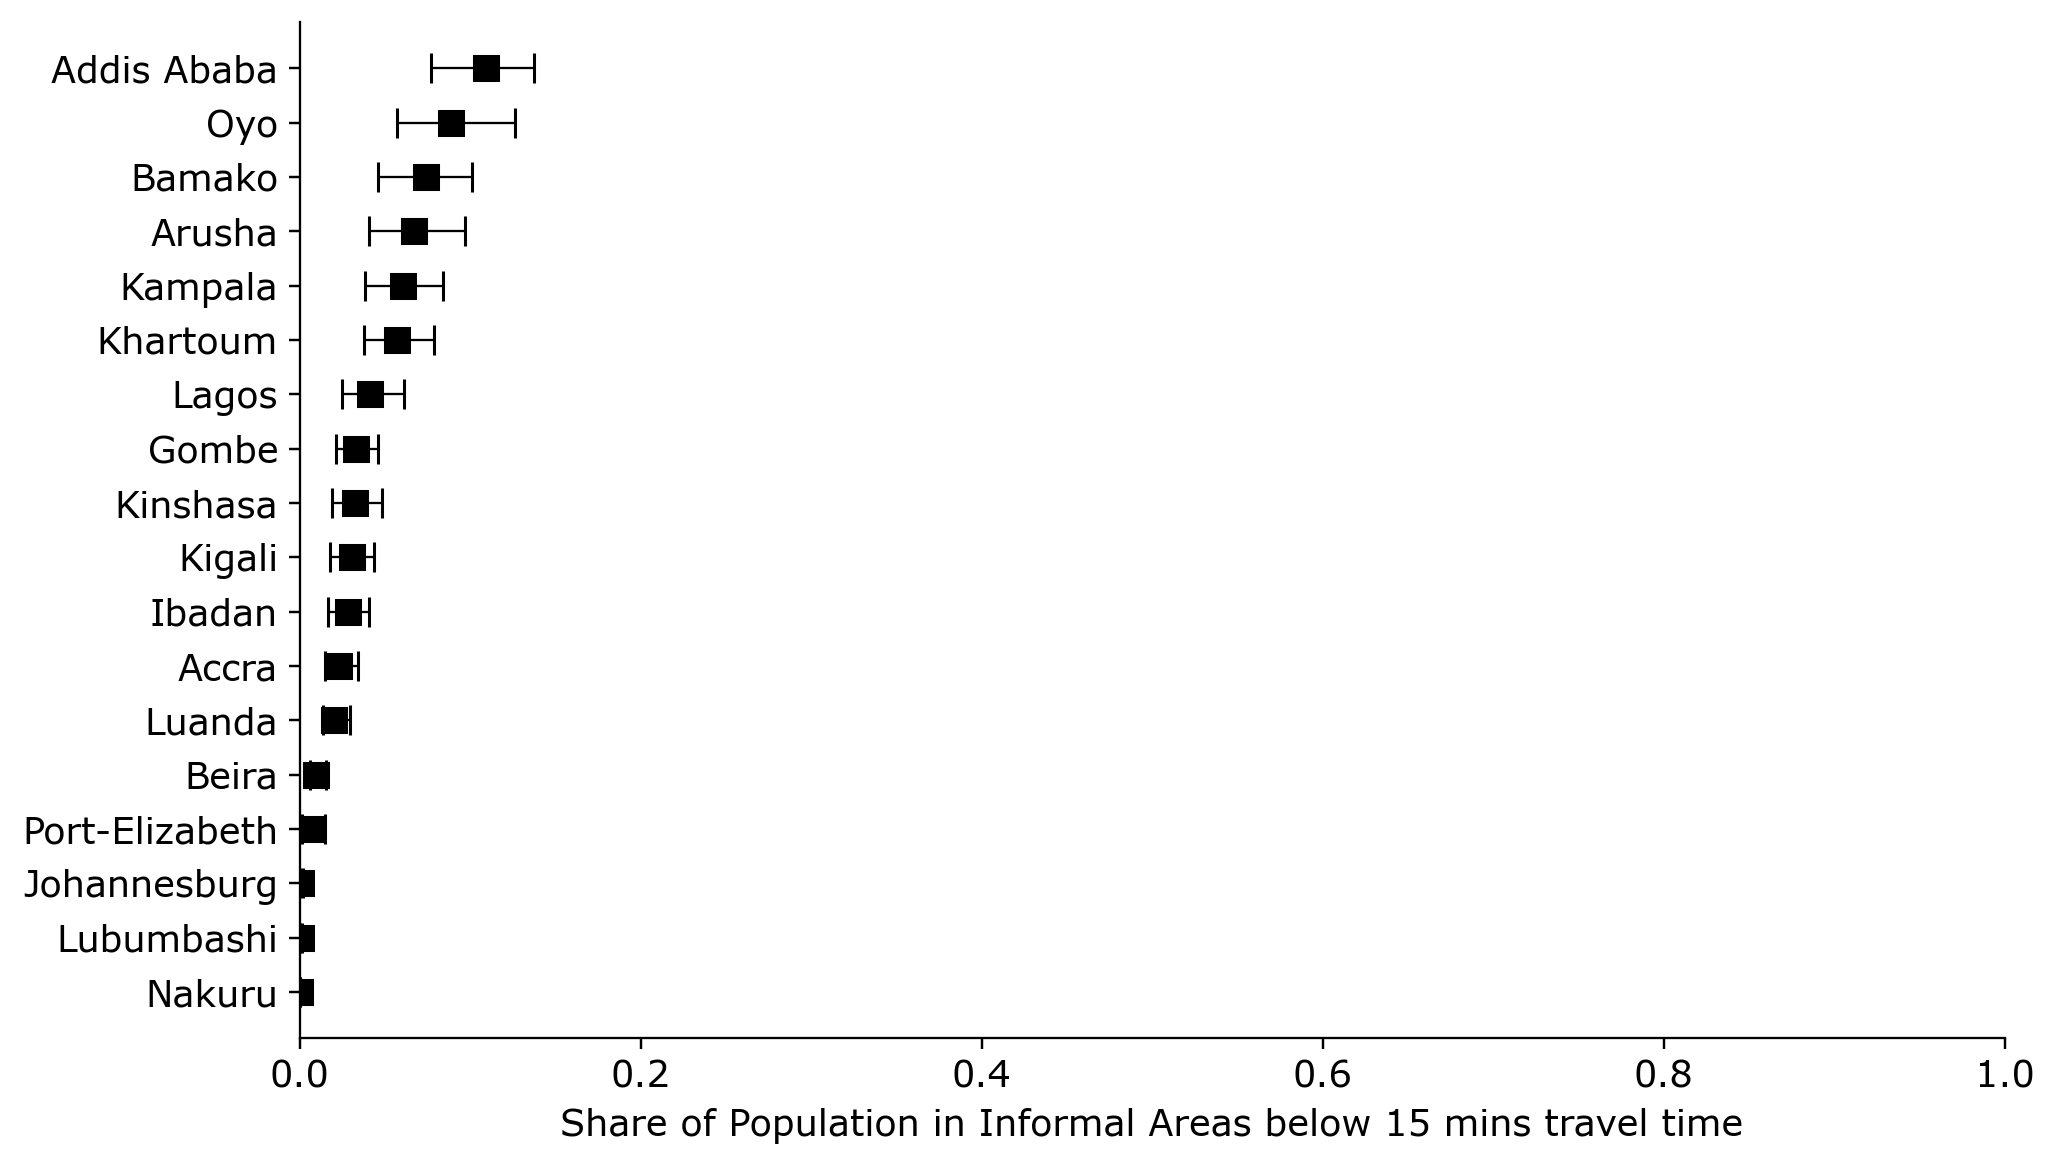

In [48]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("FST.mplstyle")

total_informal_population = 0

# Define the landuse 'Formal' or 'Informal'
landuse = 'Informal' 
# Define the health facilities 'C0' for all healthcare facilities and 'C2' for just hospitals
hospital = 'C2'
# Define the time of interest (in minutes)
time_of_interest = 15

# Define the uncertainty margin (0-1)
uncertainty = 0.2

# Create a dictionary to store data for the specified time
specified_time_data = {'City': [], 'Normalized_Population': [], 'Population_Lower': [], 'Population_Upper': []}

df = pd.read_csv(f'Total_Population.csv')

# Create a list to store dataframes for each city
city_data = []

# Load the combined CSV file
combined_csv_path = f'population_in_service_area_{hospital}.csv'  # Update with the path to your combined CSV file
df_combined = pd.read_csv(combined_csv_path)

# Iterate over unique cities in the DataFrame
unique_cities = df_combined['City'].unique()
total_max_population = 0
total_population_lower_abs = 0

for city_name in unique_cities:
    # Filter the data for the current city
    data = df_combined[df_combined['City'] == city_name]
    data = data[data['Landuse'] == landuse]
    # Sort the dataframe by time
    data = data.sort_values(by=['Time'])
    
    # Calculate the lower and upper boundaries for time
    data['time_lower'] = data['Time'] - uncertainty * data['Time']
    data['time_upper'] = data['Time'] + uncertainty * data['Time']
    
    # Calculate the corresponding population for the lower and upper time bounds
    data['population_lower'] = np.interp(data['time_lower'], data['Time'], data['Total_Population'])
    data['population_upper'] = np.interp(data['time_upper'], data['Time'], data['Total_Population'])
    
    # Add the dataframe to the list
    city_data.append(data)
    
    city_name = data['City'].iloc[1]
    filtered_df = df[(df['City'] == city_name) & (df['Landuse'] == landuse)]
    
    population_at_time = data[data['Time'] == time_of_interest]['Total_Population']

    # Calculate the normalized population for the specified time
    max_population = filtered_df['Total_Population'].iloc[-1]
    normalized_population = data[data['Time'] == time_of_interest]['Total_Population'] / max_population
    population_lower = data[data['Time'] == time_of_interest]['population_lower'] / max_population
    population_upper = data[data['Time'] == time_of_interest]['population_upper'] / max_population
    population_lower_abs = data[data['Time'] == time_of_interest]['population_lower']
    population_upper_abs = data[data['Time'] == time_of_interest]['population_upper']
    
    
    # Store data in the dictionary
    specified_time_data['City'].append(data['City'].iloc[0])
    specified_time_data['Normalized_Population'].append(normalized_population.iloc[0])
    specified_time_data['Population_Lower'].append(population_lower.iloc[0])
    specified_time_data['Population_Upper'].append(population_upper.iloc[0])

    # Add the population for the current city to the total
    total_informal_population += population_at_time.iloc[0]
    total_population_lower_abs += population_lower_abs.iloc[0]
    total_max_population += max_population
# Rearrange the cities in the second figure based on the Normalized_Population values
sorted_specified_time_data = sorted(zip(specified_time_data['City'], specified_time_data['Normalized_Population'],
                                      specified_time_data['Population_Lower'], specified_time_data['Population_Upper']),
                                  key=lambda x: x[1])

# Reverse the order to have the smallest shares first
sorted_specified_time_data = sorted_specified_time_data[::-1]

sorted_cities, sorted_normalized_pop, sorted_pop_lower, sorted_pop_upper = zip(*sorted_specified_time_data)

# Create the main population vs. time plot
plt.figure(figsize=(20, 6))
plt.subplot(121)
i=1
for data in city_data:
    if i < 9:
        linestyle = '-'
    elif i < 17:
        linestyle = '--'
    else:
        linestyle = ':'
    i = i+1
    city_name = data['City'].iloc[1]
    filtered_df = df[(df['City'] == city_name) & (df['Landuse'] == landuse)]
    max_population = filtered_df['Total_Population'].iloc[-1]
    # Normalize the population by the maximum population at time step 180
    normalized_population = data['Total_Population'] / max_population
    plt.plot(data['Time'], normalized_population, label=data['City'].iloc[0], linestyle = linestyle)
    # Add the uncertainty shading
    plt.fill_between(data['Time'], data['population_lower']/max_population, data['population_upper']/max_population, alpha=0.2)

plt.xlabel('Time (min)')
plt.xlim(0,180)
plt.ylim(0,1)
plt.ylabel('Spatial Accessibility (SA)')
#plt.title(f'Normalized {landuse} Population vs. Time with Uncertainty')
#plt.legend(loc='lower right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))




# Convert the specified_time_data dictionary to a DataFrame
specified_time_df = pd.DataFrame(specified_time_data)

# Define the file path where you want to save the CSV file
csv_file_path = f'specified_time_data_{hospital}_{landuse}_{time_of_interest}_min.csv'

# Save the DataFrame to a CSV file
specified_time_df.to_csv(csv_file_path, index=False)

print(f'Data saved to {csv_file_path}')


# Sort the result_df dataframe based on the 'Normalized_Population' column
result_df_sorted = specified_time_df.sort_values(by='Normalized_Population', ascending=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot points for each city with error bars representing uncertainties
ax.errorbar(result_df_sorted['Normalized_Population'], range(len(result_df_sorted)),
            xerr=[result_df_sorted['Normalized_Population'] - result_df_sorted['Population_Lower'],
                  result_df_sorted['Population_Upper'] - result_df_sorted['Normalized_Population']],
            fmt='s', markersize=8, color='black', capsize=5)

# Add labels and title
ax.set_yticks(range(len(result_df_sorted)))
ax.set_yticklabels(result_df_sorted['City'])
ax.set_xlabel(f'Share of Population in {landuse} Areas below {time_of_interest} mins travel time')
#ax.set_title(f'Normalized Population for Each City at {time_of_interest} mins with Uncertainties')
plt.xlim(0,1)
plt.savefig(f'Figure_{landuse}_{time_of_interest}.png', format='png', dpi=300)

# Show the plot
plt.show()


# Convert and invert only numeric columns
specified_time_df[specified_time_df.columns.difference(['City'])] = specified_time_df[specified_time_df.columns.difference(['City'])].apply(pd.to_numeric, errors='coerce')
inverted_df = pd.concat([specified_time_df[['City']], (1 - specified_time_df[specified_time_df.columns.difference(['City'])])*100], axis=1)


### Analysis of Spatial Accessibility to Healthcare Facilities Over Time for Multiple Cities

This code visualizes the spatial accessibility to healthcare facilities over time across various cities. It calculates the proportion of the population within each city's service area, normalizing it to show accessibility trends within a specified time frame (60 minutes) and including uncertainty bounds.

#### Code Breakdown:

1. **Imports and Configuration**:
   - Import the necessary libraries: `pandas` for data handling, `matplotlib` for plotting, and `numpy` for numerical calculations.
   - Set up style preferences for the plot using a custom style (`FST.mplstyle`).

2. **Parameters and Data Loading**:
   - Set the uncertainty margin (e.g. 20%), the time of interest (0-120 minutes) and the types of healthcare facilities of interest.
   - Load population data from two CSV files:
     - `population_in_service_area_<hospital>.csv`: contains population data with time information.
     - `Total_Population.csv`: contains total population data without time information.
   - Merge the two data sources based on shared columns (`City` and `Landuse`).

3. **Data Aggregation and Normalization**:
   - Aggregate and sum the population data by `City` and `Time`, normalizing the population within each city's service area against its total population.
   - This normalization provides a measure of spatial accessibility (`Normalized` column), or the proportion of each city's population with access to healthcare within the specified time.

4. **Plotting Spatial Accessibility**:
   - Set up the main plot to visualize accessibility over time for each city.
   - For each city:
     - Define a unique line style based on its order in the dataset.
     - Calculate the lower and upper time boundaries based on the uncertainty factor.
     - Use these time bounds to interpolate lower and upper population accessibility values (`population_lower` and `population_upper`), adding shaded areas around the line to represent the uncertainty range.
   - Plot the normalized population data over time for each city, with shading to show the impact of uncertainty.

5. **Customizing the Plot**:
   - Label the x-axis as "Time" and the y-axis as "Spatial Accessibility (SA)".
   - Set limits on the y-axis (0 to 1) and x-axis (0 to 120 minutes) to focus on the relevant range.
   - Display a legend outside the main plot area for easy city identification.

This visualization highlights how spatial accessibility to healthcare facilities varies over time and across cities, illustrating both accessibility levels and associated uncertainty.



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_14803/529826295.py:12: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_14803/529826295.py:12: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_14803/529826295.py:12: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4p

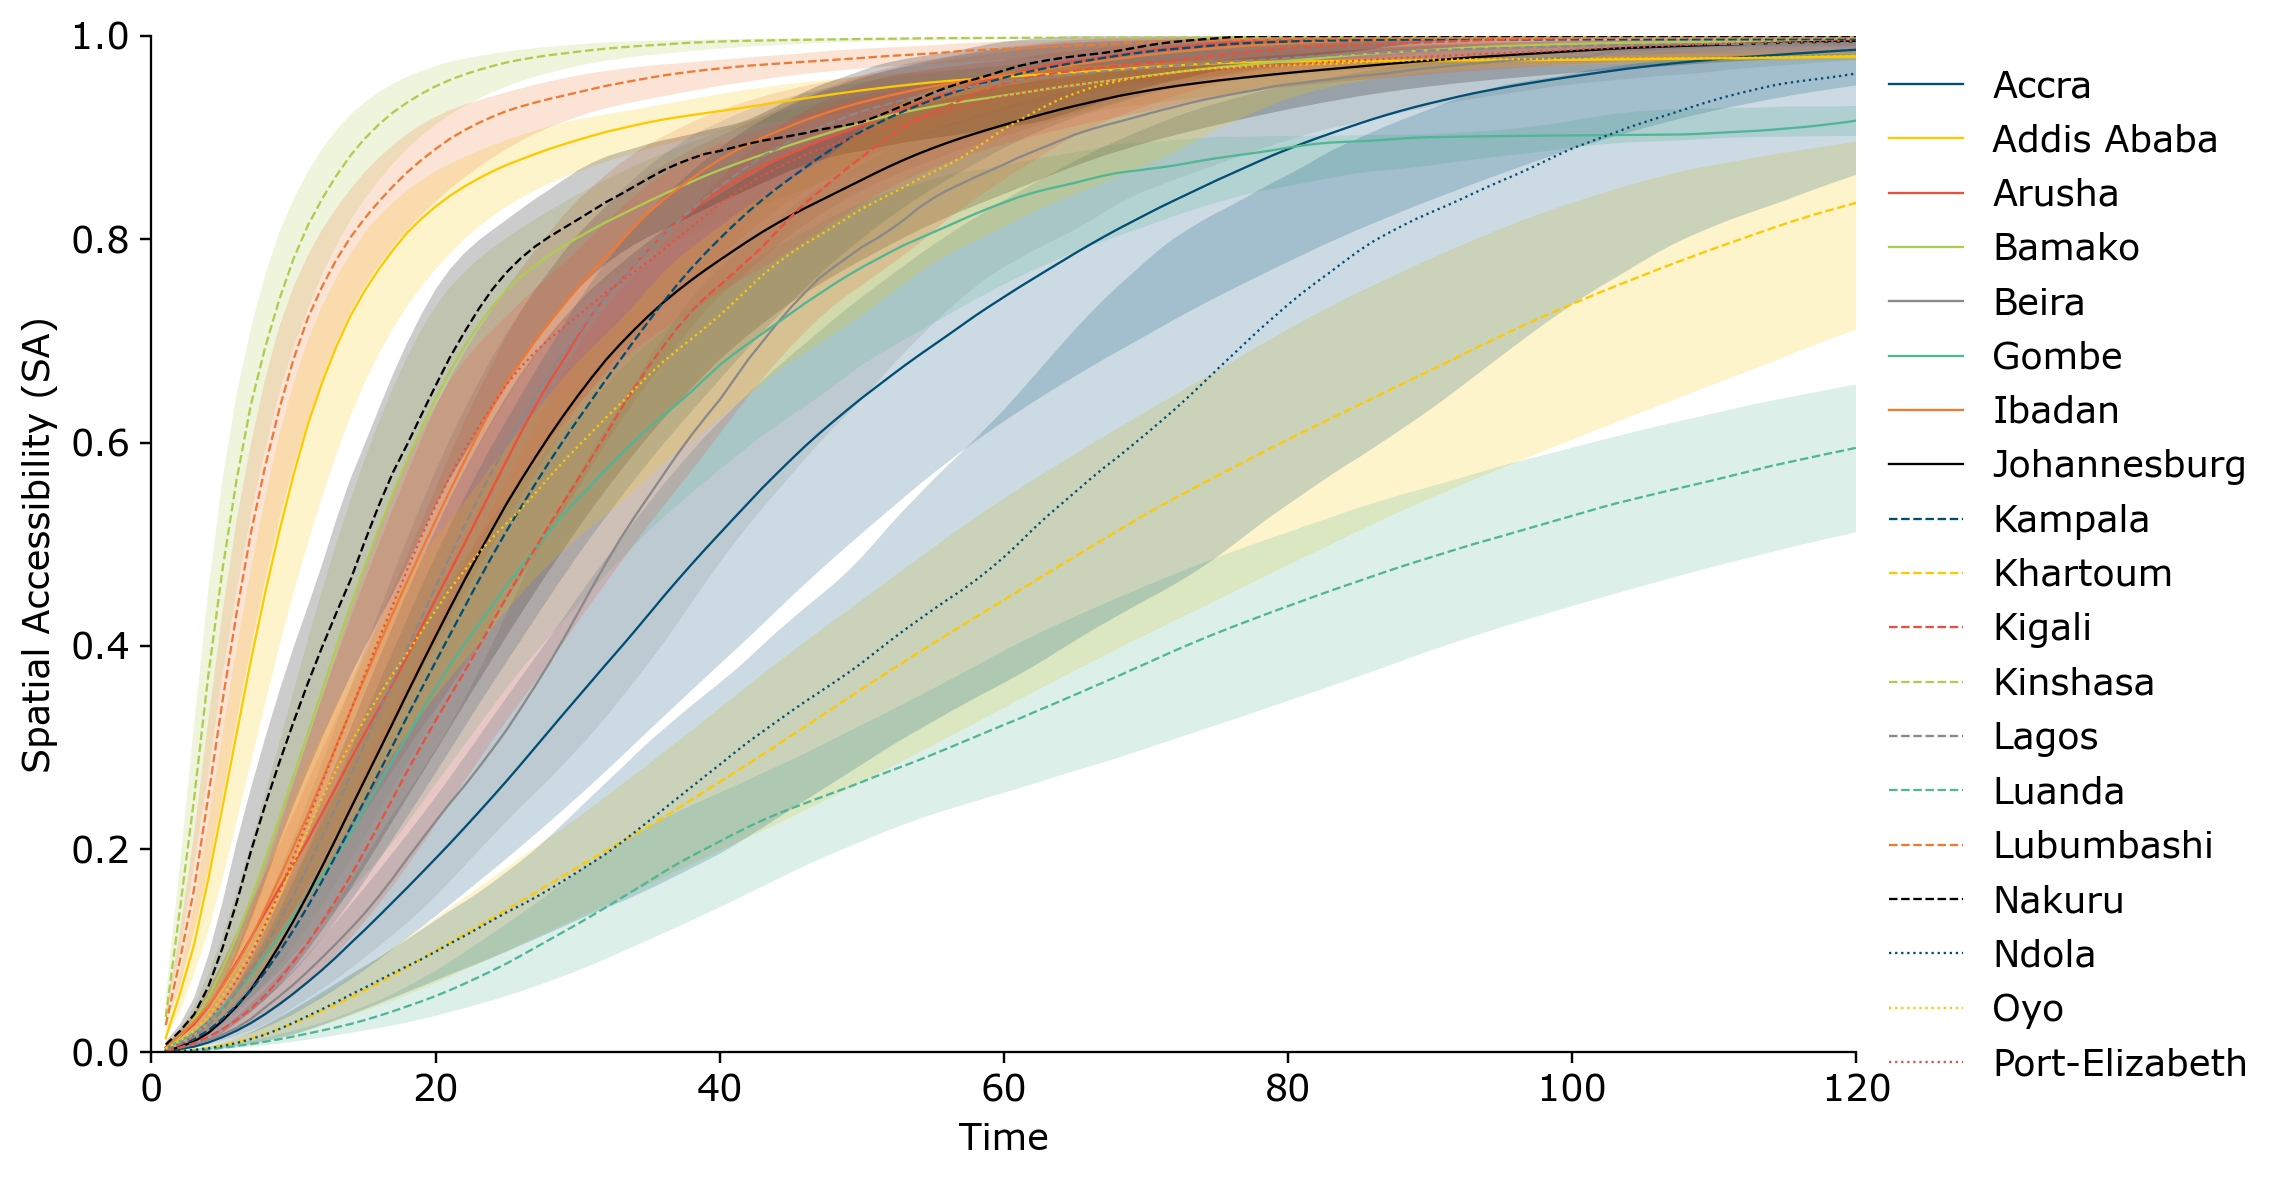

In [40]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 25 13:44:53 2023

@author: Friesen
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("FST.mplstyle")

uncertainty = 0.2
time_of_interest = 60
hospital = 'C0'

# Load the data from the first CSV file (with time information)
df1 = pd.read_csv(f'population_in_service_area_{hospital}.csv')

# Load the data from the second CSV file (without time information)
df2 = pd.read_csv(f'Total_Population.csv')
df2 = df2.drop('Time', axis=1)

# Merge the data from both CSV files based on 'City' and 'Landuse'
merged_df = pd.merge(df1, df2, on=['City', 'Landuse'])


total_df = merged_df
total_df = total_df.groupby(['City', 'Time'], as_index=False).agg({'Total_Population_x': 'sum', 'Total_Population_y': 'sum'})
total_df['Normalized']=total_df['Total_Population_x']/total_df['Total_Population_y']


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique cities and plot data for each city
cities = total_df['City'].unique()
i=1
for city in cities:
    if i < 9:
        linestyle = '-'
    elif i < 17:
        linestyle = '--'
    else:
        linestyle = ':'
    i = i+1
    city_data = total_df[total_df['City'] == city]
    # Calculate the lower and upper boundaries for time
    city_data['time_lower'] = city_data['Time'] - uncertainty * city_data['Time']
    city_data['time_upper'] = city_data['Time'] + uncertainty * city_data['Time']
    
    # Calculate the corresponding population for the lower and upper time bounds
    city_data['population_lower'] = np.interp(city_data['time_lower'], city_data['Time'], city_data['Normalized'])
    city_data['population_upper'] = np.interp(city_data['time_upper'], city_data['Time'], city_data['Normalized'])
    time = city_data['Time']
    population_x = city_data['Normalized']
    ax.plot(time, population_x, label=f'{city}', linestyle = linestyle)
    plt.fill_between(city_data['Time'], city_data['population_lower'], city_data['population_upper'], alpha=0.2)


# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Spatial Accessibility (SA)')
#ax.set_title('Total Population Over Time for All Cities')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0,1)
plt.xlim(0,120)
# Show the plot
plt.show()





### Calculation and Visualization of Relative Risk in Healthcare Accessibility for Sub-Saharan Cities

This code computes the relative risk in healthcare accessibility between formal and informal areas across sub-Saharan African cities. Specifically, it compares the proportion of the population in each area type (formal vs. informal) that can reach healthcare facilities within a specified travel time of 15 minutes.

#### Code Overview:

1. **Data Loading**:
   - Load the total population data for each city, as well as pre-calculated accessibility data (`specified_time_data`) for formal and informal areas. Please note, that the necessary csv-Files `specified_time_data_{hospital}_Formal_{time}_min.csv` can be created using the code above.
   - Aggregate city populations and load formal and informal data for the defined time threshold.

2. **Merging and Relative Risk Calculation**:
   - Merge the formal and informal accessibility data on the city name, creating a single DataFrame for analysis.
   - Calculate the **relative risk** as the ratio of accessible population shares (normalized populations) between formal and informal areas:
     - `Normalized_Population_Ratio` gives the relative accessibility risk between formal and informal areas.
     - `Population_upper_ratio` and `Population_lower_ratio` represent the uncertainty bounds for this risk measure, reflecting accessibility variability.

3. **Saving Results**:
   - Save the resulting data, including the calculated ratios and uncertainty intervals, to a CSV file for further analysis.

4. **Visualization**:
   - The code creates a plot for visualizing relative risk across cities:
     - **Relative Risk Plot**: For each city, the plot displays the `Normalized_Population_Ratio`, with error bars indicating uncertainty bounds.
     - A dashed line at relative risk = 1 marks the threshold where formal and informal accessibility is equal.
     - The x-axis is set to a logarithmic scale to better represent variations across cities.

   - This visualization highlights disparities in healthcare accessibility, allowing for comparison of relative risk across urban areas and identification of cities where informal areas face greater accessibility challenges.

This analysis provides critical insights into the relative accessibility of healthcare services in formal and informal urban settings, emphasizing areas where targeted interventions may be necessary to improve healthcare access equity.


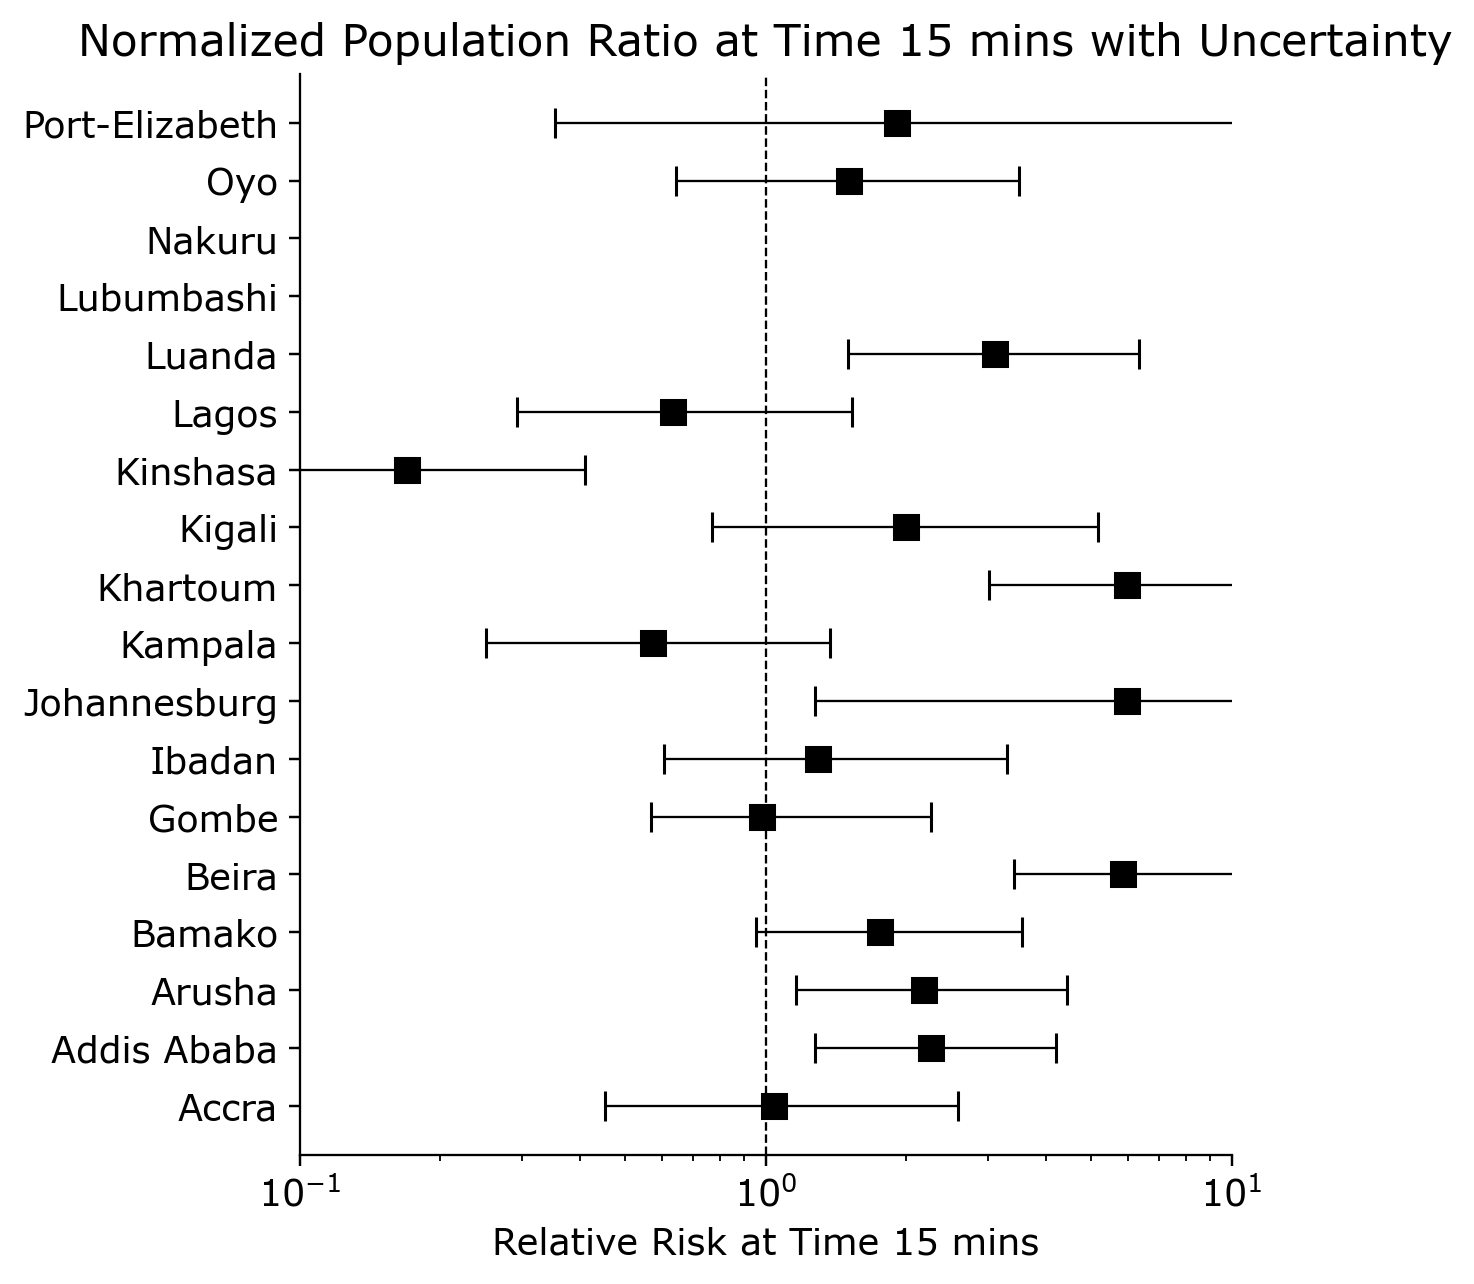

In [50]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 23 10:43:18 2024

@author: Friesen
"""
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 27 15:49:06 2023
 
@author: Friesen
"""

import pandas as pd
import matplotlib.pyplot as plt

# Read the total population data for each city
hospital = 'C2'
time = '15'
df_total_population = pd.read_csv(f'Total_Population.csv')
city_population = df_total_population.groupby('City')['Total_Population'].sum().reset_index()

# Load specified time data for Formal and Informal areas
file1 = f'specified_time_data_{hospital}_Formal_{time}_min.csv'
file2 = f'specified_time_data_{hospital}_Informal_{time}_min.csv'
df_formal = pd.read_csv(file1)
df_informal = pd.read_csv(file2)

# Merge the two DataFrames on the 'City' column
merged_df = pd.merge(df_formal, df_informal, on='City', suffixes=('_Formal', '_Informal'))

# Calculate the ratio of normalized populations and uncertainty intervals
merged_df['Normalized_Population_Ratio'] = merged_df['Normalized_Population_Formal'] / merged_df['Normalized_Population_Informal']
merged_df['Population_upper_ratio'] = merged_df['Population_Upper_Formal'] / merged_df['Population_Lower_Informal']
merged_df['Population_lower_ratio'] = merged_df['Population_Lower_Formal'] / merged_df['Population_Upper_Informal']

# Save the result to a new CSV file
result_file = f'population_ratio_with_uncertainty_{time}_{hospital}.csv'
merged_df.to_csv(result_file, index=False)


# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot points for each city with error bars representing uncertainties
ax.errorbar(
    merged_df['Normalized_Population_Ratio'],                   # X values (normalized population ratio)
    range(len(merged_df['City'])),                              # Y values (index of each city)
    xerr=[
        merged_df['Normalized_Population_Ratio'] - merged_df['Population_lower_ratio'],  # Lower bound of error
        merged_df['Population_upper_ratio'] - merged_df['Normalized_Population_Ratio']   # Upper bound of error
    ],
    fmt='s', markersize=8, color='black', capsize=5            # Marker style and error bar cap size
)

# Customize the plot
plt.axvline(x=1, color='black', linestyle='--')               # Dashed line at relative risk = 1
ax.set_yticks(range(len(merged_df['City'])))
ax.set_yticklabels(merged_df['City'])
ax.set_xlabel(f'Relative Risk at Time {time} mins')
ax.set_title(f'Normalized Population Ratio at Time {time} mins with Uncertainty')
plt.xlim(0.1, 10)                                             # Adjust x-axis limits as needed
plt.xscale('log')                                             # Logarithmic scale for x-axis
plt.tight_layout()

# Show the plot
plt.show()

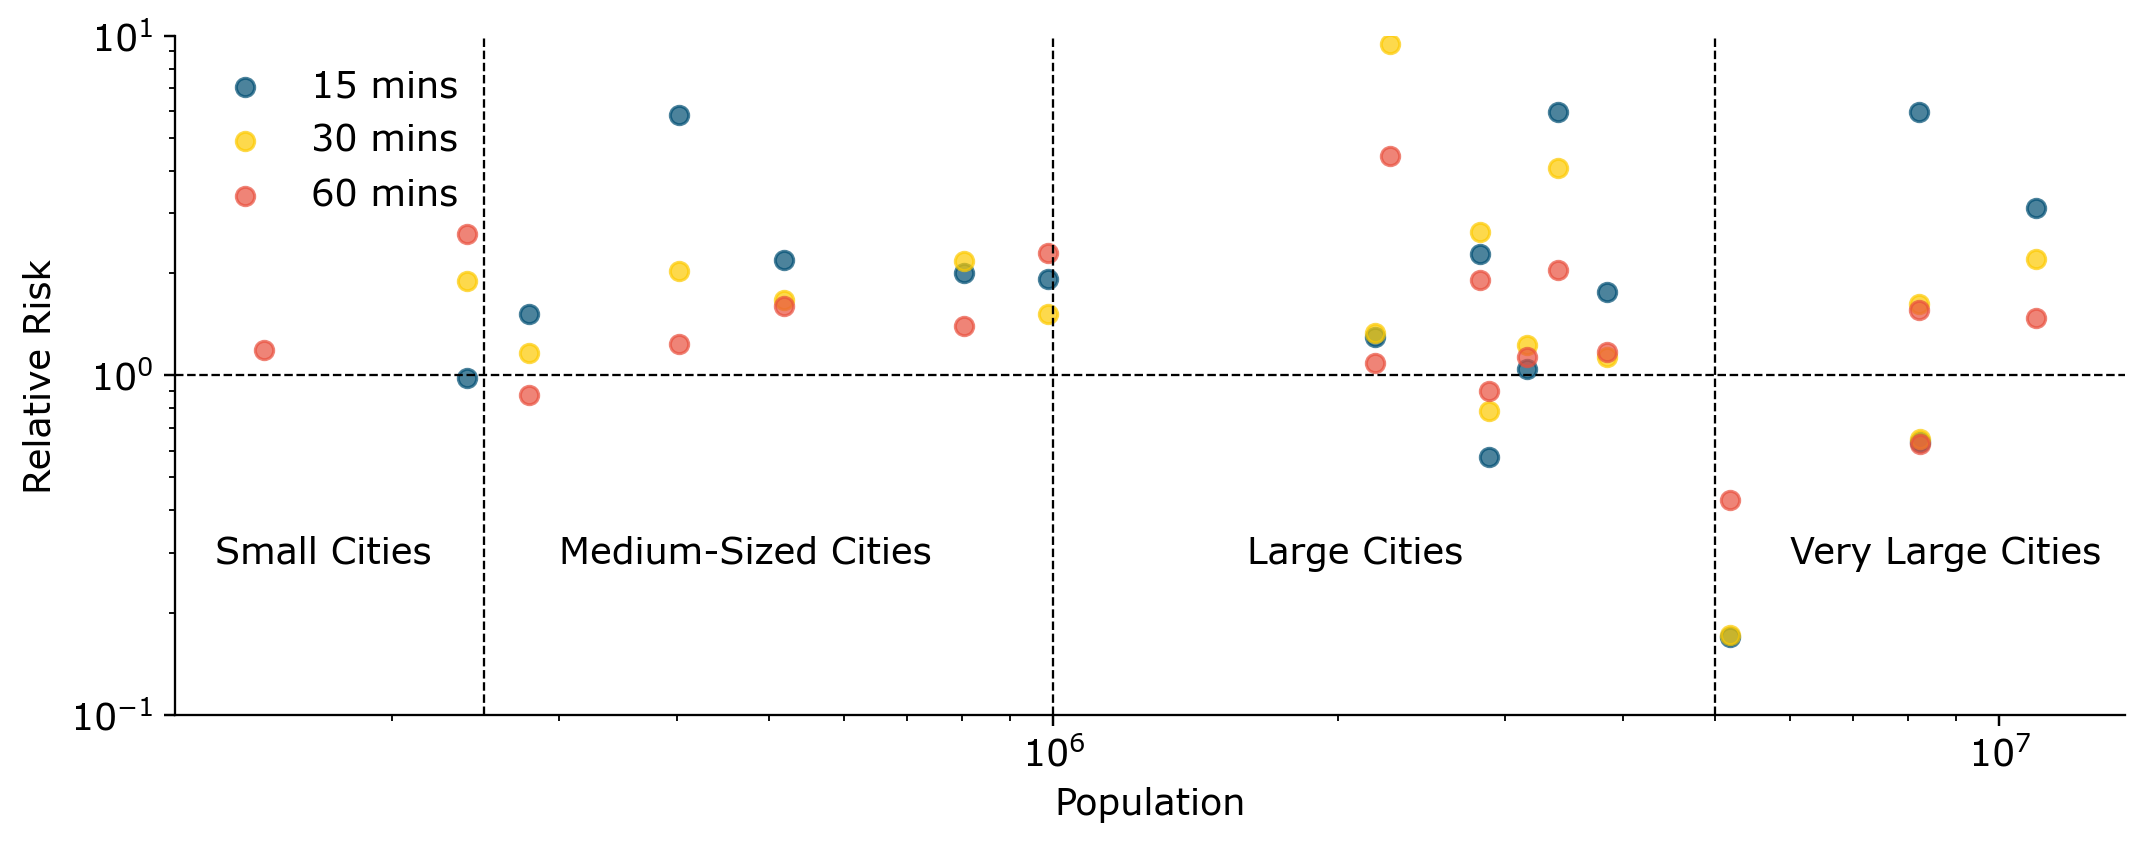

In [15]:
# Merge city_population DataFrame with the result DataFrame for each time
analysis_df = pd.merge(city_population, merged_df, on='City')

# List of times
times = ['15', '30', '60']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Iterate over each time
for time in times:
    # Load the CSV file for the current time
    file = f'population_ratio_with_uncertainty_{time}_{hospital}.csv'
    analysis_df = pd.read_csv(file)

    # Merge with city_population DataFrame to get 'Total_Population'
    analysis_df = pd.merge(city_population, analysis_df, on='City')

    # Scatter plot with different markers for each time
    ax.scatter(analysis_df['Total_Population'],
               analysis_df['Normalized_Population_Ratio'],
               label=f'{time} mins',
               alpha=0.7)

# Adding horizontal line at relative risk value 1
ax.axhline(y=1, color='black', linestyle='--')

# Adding vertical lines for population thresholds
ax.axvline(x=250000, color='black', linestyle='--')
ax.axvline(x=1000000, color='black', linestyle='--')
ax.axvline(x=5000000, color='black', linestyle='--')

# Adding text boxes between vertical lines
ax.text(130000, 0.3, 'Small Cities', rotation=0, verticalalignment='center')
ax.text(300000, 0.3, 'Medium-Sized Cities', rotation=0, verticalalignment='center')
ax.text(1600000, 0.3, 'Large Cities', rotation=0, verticalalignment='center')
ax.text(6000000, 0.3, 'Very Large Cities', rotation=0, verticalalignment='center')

# Setting x-axis and y-axis to log scale
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(0.1, 10)

# Adding labels and title
ax.set_xlabel('Population')
ax.set_ylabel('Relative Risk')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
